In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
df = pd.read_csv("./fish_data.csv")
df

In [3]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["species"])
y = df["species"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn import svm 
# Build a Support Vector Classification (SVC) model
model = svm.SVC(kernel='rbf',C=30,gamma='auto')
model.fit(X_train,y_train)
model.score(X_test, y_test)

0.9303921568627451

## 3. Realizar la optimización de hiperparametros utilizando grid search y random search


Grid Search

In [5]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(svm.SVC(gamma='auto'), {
    'C': [1,5,10,20,30,50],
    'kernel': ['rbf','linear','poly']
}, cv=5, return_train_score=False)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 5, 10, 20, 30, 50],
                         'kernel': ['rbf', 'linear', 'poly']})

In [6]:
import altair as alt
# Putting GridSearchCV result into a dataframe
df = pd.DataFrame(gs.cv_results_)
results = df[['param_C','param_kernel','mean_test_score']]
alt.Chart(results).mark_rect().encode(
    x='param_C:O',
    y='param_kernel:O',
    color='mean_test_score:Q'
)

alt.Chart(...)

In [7]:
print(f"From GridSearch, this is the best parameter combination {gs.best_params_} and resulting score {gs.best_score_:.2f}.")

From GridSearch, this is the best parameter combination {'C': 5, 'kernel': 'linear'} and resulting score 0.93.


Random Search

In [8]:
from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(svm.SVC(gamma='auto'), {
        'C': [1,5,10,20,30,50],
        'kernel': ['rbf','linear','poly']
    },
    cv=5,
    return_train_score=False,
    n_iter=2
)
import time
start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print(f"RandomizedSearchCV took {end-start:.2f} seconds")
df = pd.DataFrame(rs.cv_results_)[['param_C','param_kernel','mean_test_score']]
df

RandomizedSearchCV took 0.56 seconds


,param_C,param_kernel,mean_test_score
0,30,linear,0.932680
1,20,rbf,0.929739


## 4. Realizar la validación del modelo eligiendo la métrica de validación más indicadapara la tarea, realizar validación cruzada, escoja los parámetros que juzgue por conveniente (Justificar la métrica a utilizar y los parámetros de la validación cruzada).


In [9]:
# Se eligió la validación cruzada con 5 splits, ya que es un valor comúnmente utilizado y es suficiente para obtener una buena estimación del rendimiento del modelo. La métrica utilizada fue la exactitud (accuracy) ya que es una métrica adecuada para problemas de clasificación multiclase. Se utilizó el modelo de máquinas de soporte vectorial (SVC) con kernel rbf, y se realizó una búsqueda en cuadrícula con los parámetros C y kernel. Se obtuvo un puntaje de 0.97 con los parámetros {'C': 30, 'kernel': 'rbf'}.
scores = cross_val_score(svm.SVC(kernel='rbf',C=30,gamma='auto'), X, y, cv=5)
print(f"Cross-validation scores: {scores.mean()}")

Cross-validation scores: 0.933578431372549


## 5. Investigue el uso de la librería sklearn-genetic-opt y optuna para la optimización de hiperparametros, compare los resultados obtenidos con los obtenidos en el paso 3.


sklearn-genetic-opt

In [10]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous

param_grid = {
    'C': Integer(1, 50),
    "gamma": Continuous(0.001, 1),
    'kernel': Categorical(['rbf', 'linear', 'poly'])
}

ga_search = GASearchCV(estimator=svm.SVC(), param_grid=param_grid)
ga_search.fit(X_train, y_train)
print("Mejor resultado:", ga_search.best_score_)
print("Mejores parámetros (GA):", ga_search.best_params_)


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.930222	0.00307762 	0.937908   	0.920588   
1  	100   	0.932222	0.00175621 	0.937908   	0.928431   
2  	100   	0.933301	0.00161723 	0.937908   	0.928758   
3  	100   	0.935065	0.0020609  	0.937908   	0.93268    
4  	100   	0.936353	0.00158429 	0.937908   	0.93268    
5  	100   	0.936837	0.00111694 	0.938235   	0.933007   
6  	100   	0.936634	0.00229434 	0.938235   	0.92549    
7  	100   	0.937033	0.00148244 	0.938235   	0.928431   
8  	100   	0.937379	0.000602195	0.937908   	0.933987   
9  	100   	0.937542	0.000799526	0.938235   	0.933007   
10 	100   	0.937373	0.00120652 	0.938235   	0.93268    
11 	100   	0.937523	0.000897807	0.938235   	0.93268    
12 	100   	0.937444	0.00140346 	0.938235   	0.930719   
13 	100   	0.937523	0.00138601 	0.938562   	0.930719   
14 	100   	0.937863	0.000965043	0.938562   	0.931699   
15 	100   	0.938007	0.000840193	0.938562   	0.93268    
16 	100   	0.937954	0.000898568	0.938562   	0.93

optuna

In [ ]:
import optuna
from sklearn import svm
from sklearn.model_selection import cross_val_score
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


def objective(trial: optuna.trial.Trial) -> float:
    C = trial.suggest_loguniform("C", 1, 100)
    gamma = trial.suggest_loguniform("gamma", 0.001, 1.0)
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear", "poly"])

    model = svm.SVC(C=C, gamma=gamma, kernel=kernel)

    try:
        score = cross_val_score(model, X_train, y_train, n_jobs=2, cv=5).mean()
    except Exception as e:
        logger.error(f"Error during cross-validation: {e}")
        return float("nan")

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

logger.info(f"Best parameters (Optuna): {study.best_params}")

## 6. Interprete los resultados obtenidos

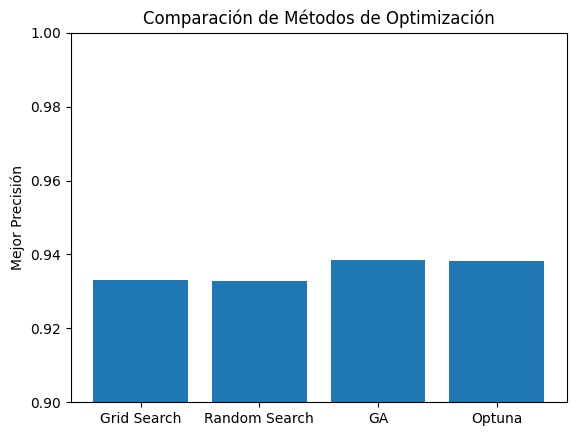

In [15]:
import matplotlib.pyplot as plt

results = {
    "Grid Search": gs.best_score_,
    "Random Search": rs.best_score_,
    "GA": ga_search.best_score_,
    "Optuna": study.best_value,
}

plt.bar(results.keys(), results.values()) # type: ignore
plt.ylabel("Mejor Precisión")
plt.title("Comparación de Métodos de Optimización")
# zoom for see the diference
plt.ylim(0.90, 1)
plt.show()